In [189]:
!pip install pandas
!pip install np
!pip install matplotlib
!pip install seaborn
!pip install scipy


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mining_extension import check_logging 
import re
import seaborn as sns
import datetime
from scipy.stats import chi2_contingency as chi2

sns.set_theme()
check_logging("http://3.249.245.244:9999")

Request successful!


# Data Engineering

Clear up the data, remove END, split by delimeters.

In [191]:
PATH_TO_DATA = "./data/task1/jetnet_logs/jetnet_logs.txt"

data = open(PATH_TO_DATA, "r").read().split('@')
data = list(filter(len, data))

df = pd.DataFrame(
    columns = ["user_id", "session_num", "action_time", "action_name"] 
)

user_id_lst, session_num_lst, action_time_lst, action_name_lst = [], [], [], []

for i, x in enumerate(data):
    if len(x.strip()) == 0:
        continue
        
    tmp = re.split('-> |--> |: |\n', data[i])
    tmp = list(filter(len, tmp))
    
    user = tmp[0]
    
    match = re.match(r"User(\d+)", user)
    user_id = int(match.group(1))

    for action in tmp[1:]:
        action = action.strip()
        
        if len(action) == 0:
            continue
            
        action_pattern = r"^(Action_\d+|END) "
        date_pattern = r"(\d{2})/(\d{2})/(\d{2})"
        time_pattern = r"(\d{2}):(\d{2}):(\d{2})"

        # Parse the action name
        match = re.match(action_pattern, action)

        if match:
            action_name = match.group(1)
        else:
            action_name = np.NaN

        # Parse the date and time fields, if present
        date_match = re.search(date_pattern, action)
        time_match = re.search(time_pattern, action)

        if date_match and time_match:
            day, month, year = date_match.groups()
            hour, minute, second = time_match.groups()
            year = "20" + year
            action_time = pd.Timestamp(int(year), int(month), int(day), int(hour), int(minute), int(second))
        else:
            action_time = np.NaN

        user_id_lst.append(user_id) 
        session_num_lst.append(i)
        
        action_time_lst.append(action_time)
        action_name_lst.append(action_name)

df = pd.DataFrame(
    {
        "user_id": user_id_lst,
        "session_num": session_num_lst, 
        "action_time": action_time_lst, 
        "action_name": action_name_lst
    }
)

df

,user_id,session_num,action_time,action_name
0,92,0,2019-10-15 18:08:02,Action_3
1,92,0,2019-10-15 18:54:49,Action_1
2,92,0,2019-10-15 20:02:54,Action_10
3,92,0,2019-10-15 20:26:56,Action_7
4,92,0,2019-10-15 20:51:09,Action_0
...,...,...,...,...
2053705,112,87570,2021-07-08 03:18:55,END
2053706,76,87571,2021-07-28 14:35:47,Action_7
2053707,76,87571,2021-07-28 15:09:53,Action_9
2053708,76,87571,2021-07-28 14:59:10,Action_1


In [192]:
df = df[(df["action_name"] != "END")]

In [193]:
df.sort_values("action_time")

,user_id,session_num,action_time,action_name
957130,122,40830,2019-09-20 13:44:16,Action_7
759182,103,32306,2019-09-20 13:45:07,Action_7
1462833,118,62379,2019-09-20 13:59:04,Action_3
1493766,81,63702,2019-09-20 14:08:06,Action_10
1462834,118,62379,2019-09-20 14:22:39,Action_7
...,...,...,...,...
2050269,102,87430,NaT,Action_7
2050980,129,87461,NaT,Action_7
2051482,94,87481,NaT,Action_0
2051813,112,87494,NaT,Action_10


In [212]:
df2 = df.groupby("session_num", as_index=False)["action_time"].min()
df2 = df2.sort_values("action_time")
tmp = df2["session_num"].reset_index(drop=True)
tmp = pd.Series(tmp.index, index=tmp.values)

df['new_session_num'] = df['session_num'].map(tmp)

df.sort_values("action_time").head(10)

,user_id,session_num,action_time,action_name,new_session_num,date,day_of_week
957130,122,40830,2019-09-20 13:44:16,Action_7,0,2019-09-20,4
759182,103,32306,2019-09-20 13:45:07,Action_7,1,2019-09-20,4
1462833,118,62379,2019-09-20 13:59:04,Action_3,2,2019-09-20,4
1493766,81,63702,2019-09-20 14:08:06,Action_10,3,2019-09-20,4
1462834,118,62379,2019-09-20 14:22:39,Action_7,2,2019-09-20,4
1462835,118,62379,2019-09-20 14:25:24,Action_10,2,2019-09-20,4
759184,103,32306,2019-09-20 14:27:15,Action_4,1,2019-09-20,4
759185,103,32306,2019-09-20 14:27:19,Action_4,1,2019-09-20,4
759183,103,32306,2019-09-20 14:28:28,Action_7,1,2019-09-20,4
754337,50,32091,2019-09-20 14:31:04,Action_7,4,2019-09-20,4


# Metrics Evaluation

In [195]:
df = df.dropna()
df.groupby("user_id").count()['session_num'].mean()

13789.748251748251

In [196]:
df1 = df
df1["date"] = df['action_time'].dt.date

res = df1[["user_id", "date", "session_num"]].groupby(["user_id", "date"]).count().groupby("user_id").mean()
res.rename(columns={"session_num": "mean"})

,mean
user_id,
0,23.339960
1,40.324638
2,33.471519
3,29.834416
4,15.492308
...,...
138,20.964803
139,40.530702
140,35.830435


## The probability of repeating the same action three times in a row during one session

In [197]:
df.sort_values("action_time", inplace=True)
df2 = df.groupby("session_num")["action_name"].agg(list).reset_index()

def repeats(lst):
    for i in range(2, len(lst)):
        if lst[i] == lst[i - 1] == lst[i - 2]:
            return True
    return False

df2["action_name"].apply(repeats).sum() / len(df["session_num"].unique())

0.32555555555555554

## The 0.95 quantile of distribution of time delta between the actions of the same type distribution during one session

In [198]:
df.dropna().groupby(["session_num", "action_name"])["action_time"].diff().quantile(0.95)

Timedelta('0 days 07:38:24.750000')

## Is there statistical difference of activity in different days of the week? And between weekends and workdays?

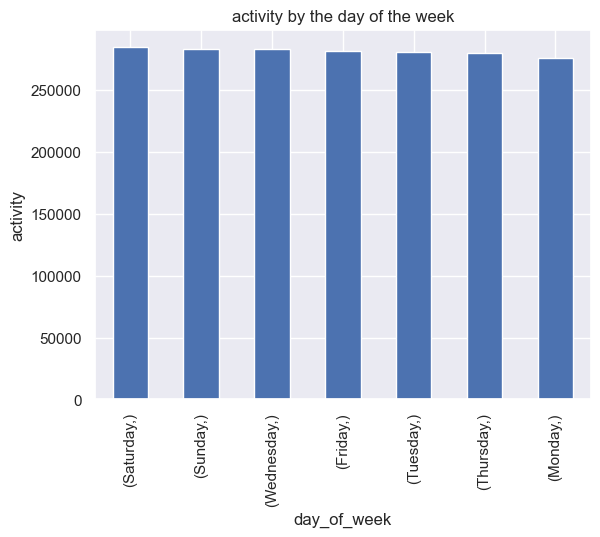

In [199]:
df.dropna(inplace=True)
df1 = df
df1["day_of_week"] = df["action_time"].dt.day_name()

df2 = df1[["day_of_week"]].value_counts().plot(kind='bar')

plt.ylabel("activity")
plt.title("activity by the day of the week")
plt.show()

Text(0, 0.5, 'average per day')

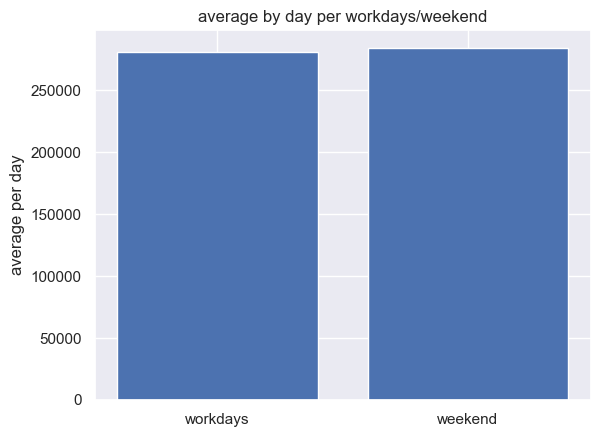

In [200]:
df.dropna(inplace=True)
df1 = df
df1["day_of_week"] = df["action_time"].dt.day_of_week

df2 = df1[["day_of_week"]].value_counts()
weekend = (df2.loc[5].values[0] + df2.loc[6].values[0])
workdays = (df2.sum() - weekend)

plt.bar(x=["workdays", "weekend"], height=[workdays / 5, weekend / 2])
plt.title("average by day per workdays/weekend")
plt.ylabel("average per day")

In [201]:
# insignificant

## My own metrics

In [202]:
"""
ideas: 
- User activity / actions per minute: length / num_of_actions
User that are faster might use techniques that would help others to improve their productivity

- Ngramms and Skipgrams of actions:
It helps to see the most commonly used features of notebooks and how what can be united and automated.

- The last sequence of moves before the end of the session, this routine might be automated, 
For example the developer could delete the comments that he made and clean up the code and this can be
automated.

- Spammed actions: Count actions that are used extremely frequently during within a narrow time
window, those actions make user click the same button or repeat the same process over and over.
Can be automated.

"""

'\nideas: \n- User activity / actions per minute: length / num_of_actions\nUser that are faster might use techniques that would help others to improve their productivity\n\n- Ngramms and Skipgrams of actions:\nIt helps to see the most commonly used features of notebooks and how what can be united and automated.\n\n- The last sequence of moves before the end of the session, this routine might be automated, \nFor example the developer could delete the comments that he made and clean up the code and this can be\nautomated.\n\n- Spammed actions: Count actions that are used extremely frequently during within a narrow time\nwindow, those actions make user click the same button or repeat the same process over and over.\nCan be automated.\n\n'

# Visualization

## the time series (line plot) of count of different actions by days

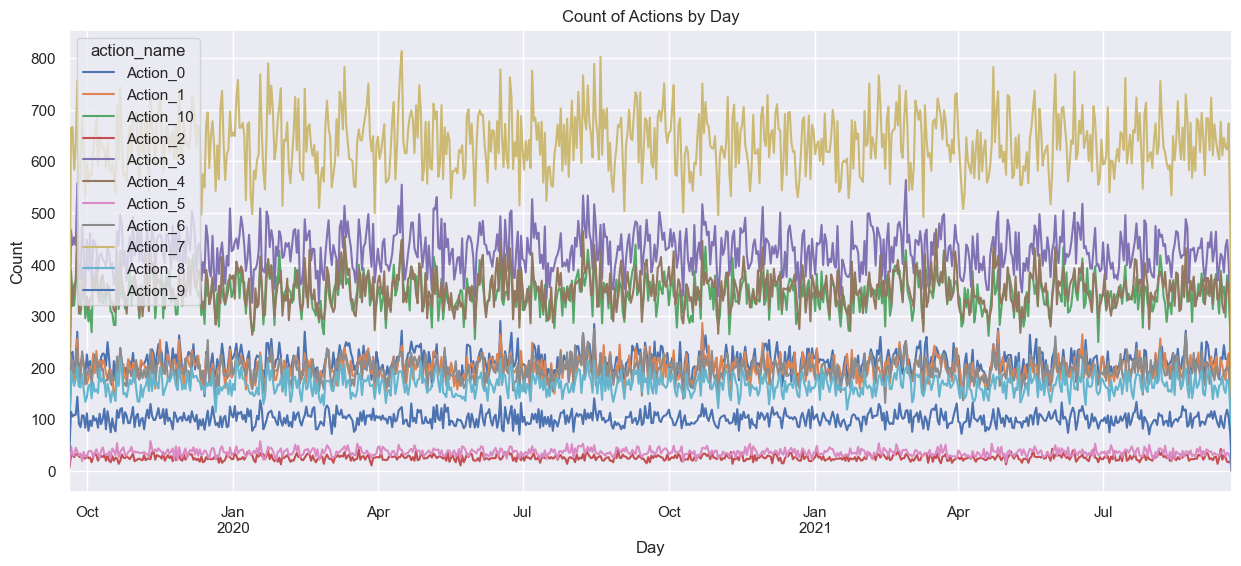

In [203]:
counts = df.groupby([pd.Grouper(key='action_time', freq='D'), 'action_name']).size().unstack(fill_value=0)
counts.plot(kind='line', figsize=(15, 6))

plt.title("Count of Actions by Day")
plt.xlabel("Day")
plt.ylabel("Count")
plt.show()

## The barchart of different actions counts


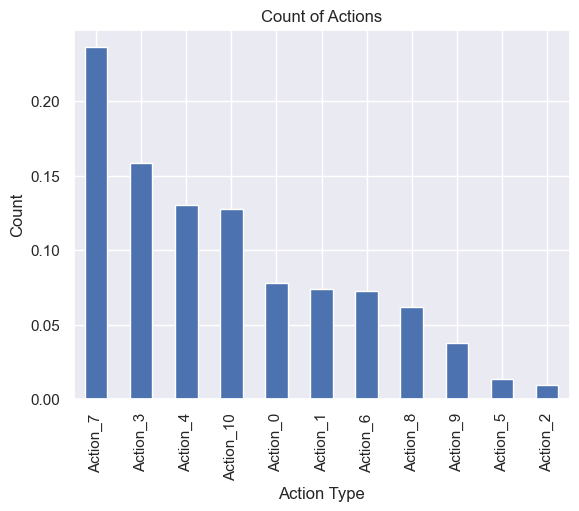

In [204]:
counts = df['action_name'].value_counts(normalize=True)

counts.plot(kind='bar')
plt.title("Count of Actions")
plt.xlabel("Action Type")
plt.ylabel("Count")
plt.show()

## The heatmap of `action_i` - `action_j` - count where count is a count of `action_i` right after the `action_j`

<Axes: xlabel='action_j', ylabel='action_i'>

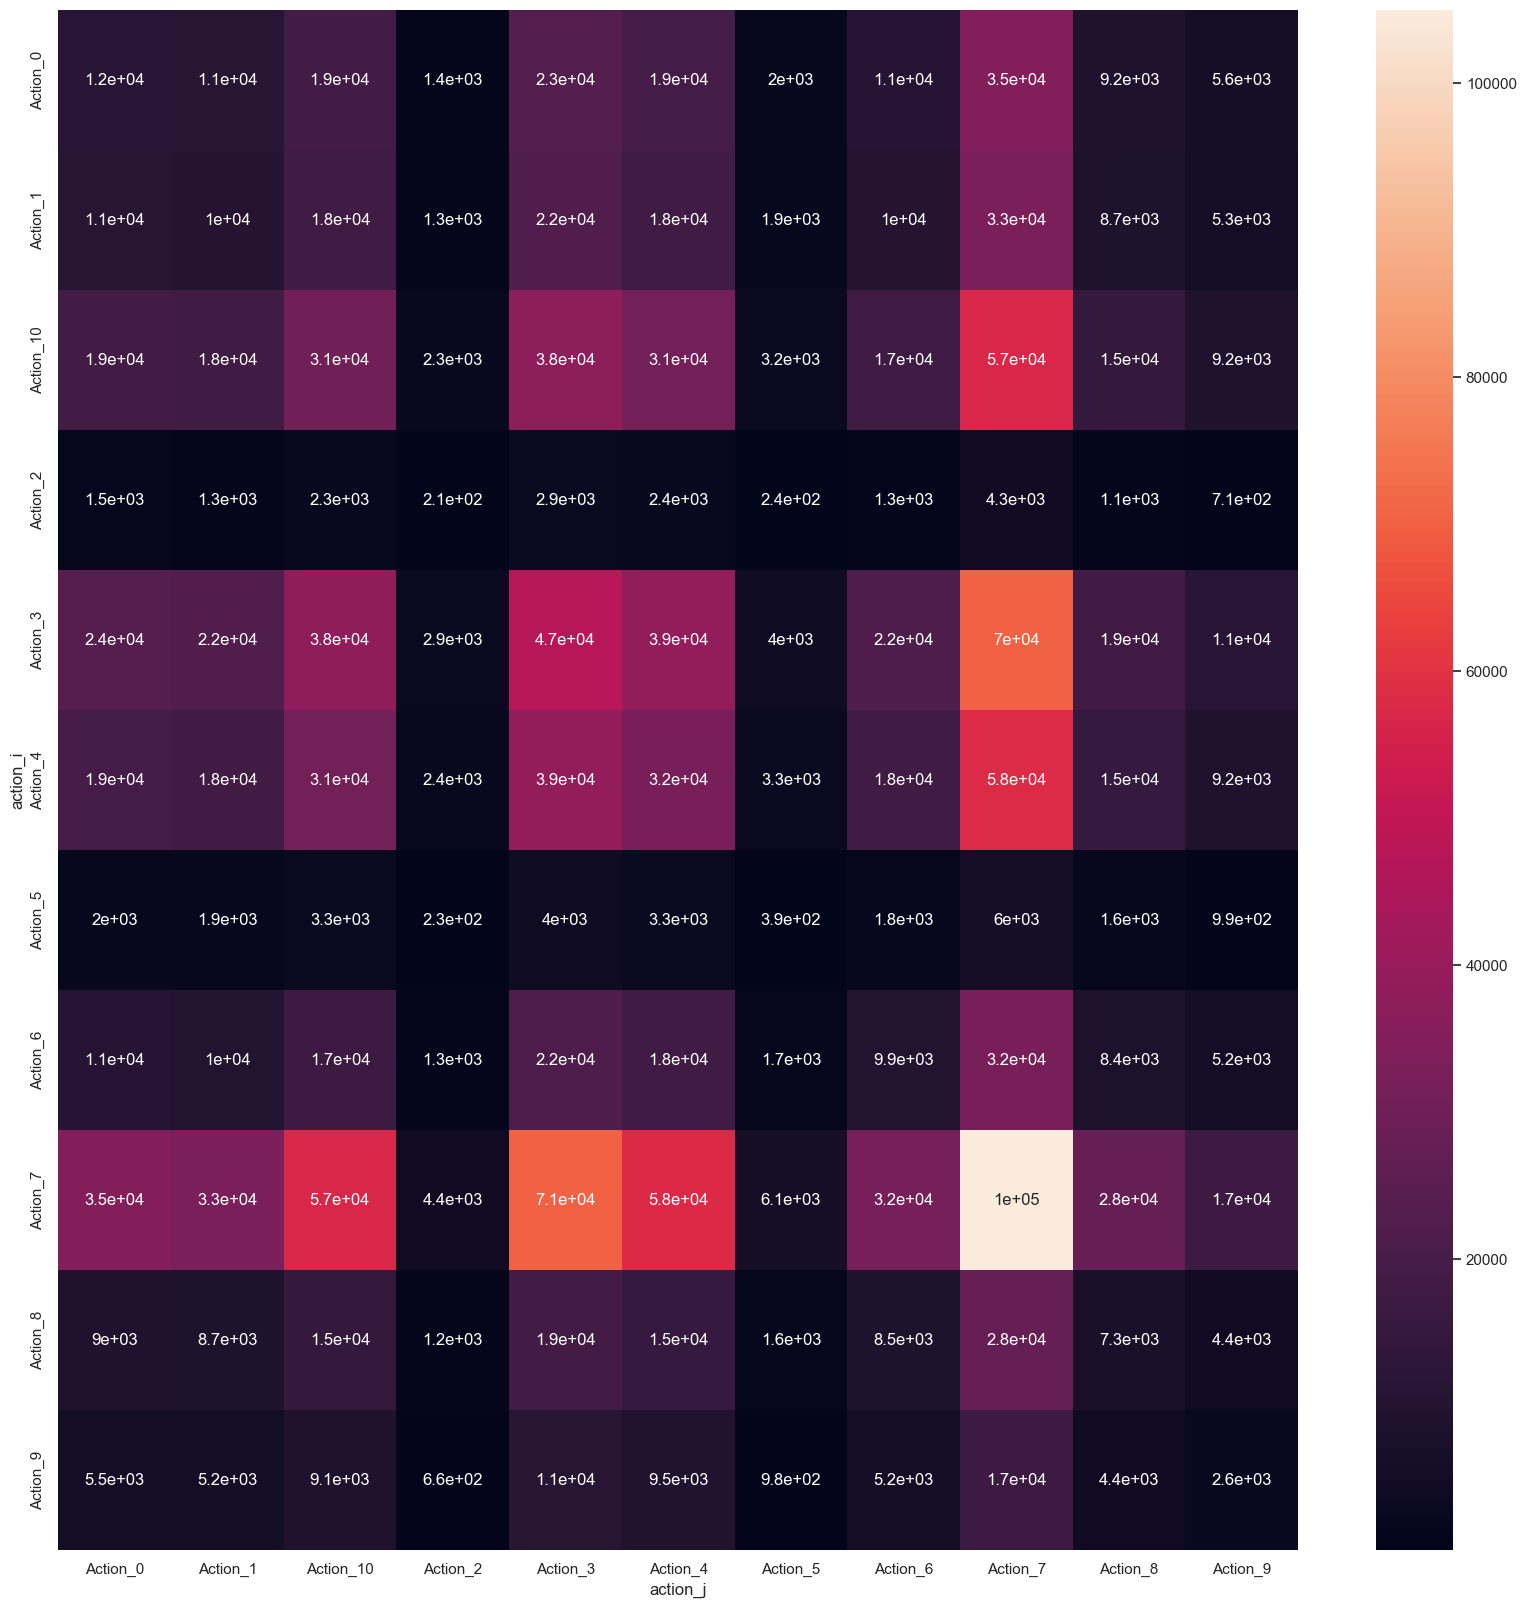

In [205]:
df2 = df.groupby("session_num")["action_name"].agg(list).reset_index()

unique_actions = sorted(df["action_name"].unique())
d = {(x, y): 0 for x in unique_actions for y in unique_actions}

def calc_2gram(lst):
    for i in range(1, len(lst)):
        d[(lst[i - 1], lst[i])] += 1

df2["action_name"].apply(calc_2gram)

df1 = pd.DataFrame.from_dict(d, orient='index', columns=['count'])

# Split the index into separate columns
df1[['action_i', 'action_j']] = pd.DataFrame(df1.index.tolist(), index=df1.index)

matrix = df1.pivot(index='action_i', columns='action_j', values='count')
plt.figure(figsize=(20, 20))
sns.heatmap(matrix, annot=True)


## the time series (line plot) of all actions of the top 20 percent of active users by days

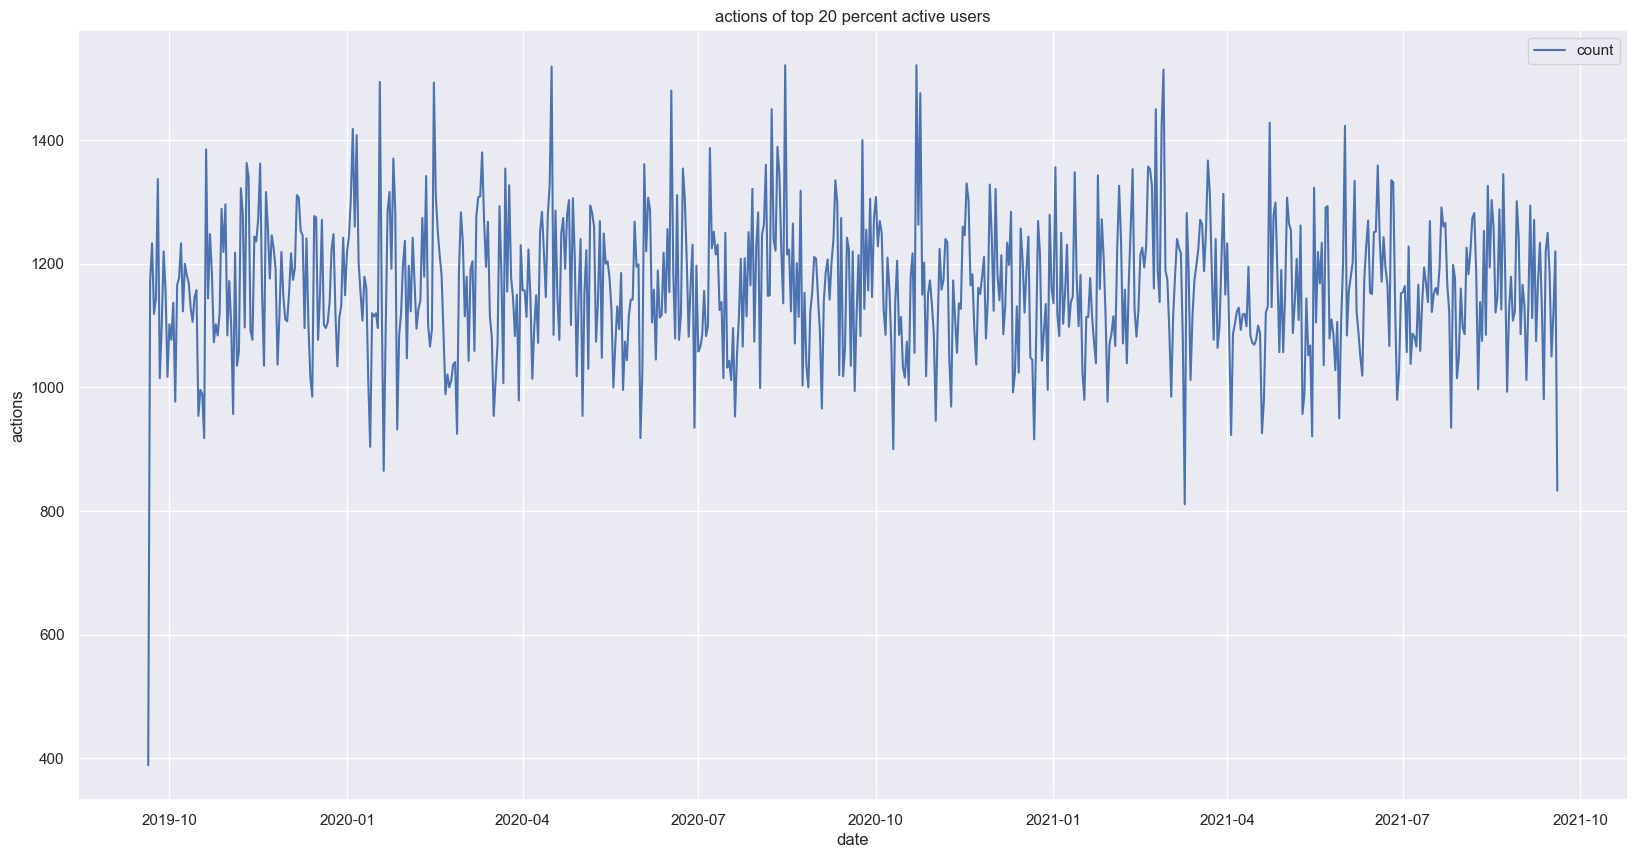

In [206]:
def select_top_20_percent(group):
    return group.nlargest(int(len(group) * 0.2))

df1 = df
df1["date"] = df['action_time'].dt.date

df1 = df1[["user_id", "date"]].groupby(["date", "user_id"]).value_counts().reset_index()

top_20_percent = df1.groupby('date')['count'].apply(select_top_20_percent).reset_index()
counts = top_20_percent.groupby("date").sum().drop(columns="level_1")

counts.plot(kind="line", figsize=(20, 10))
plt.title("actions of top 20 percent active users")
plt.xlabel("date")
plt.ylabel("actions")
plt.show()

## My own visualization

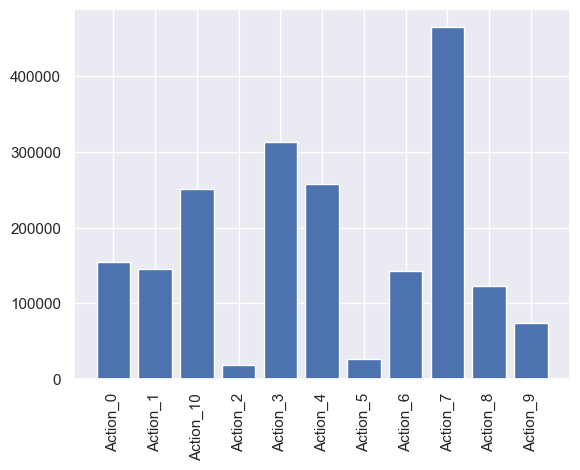

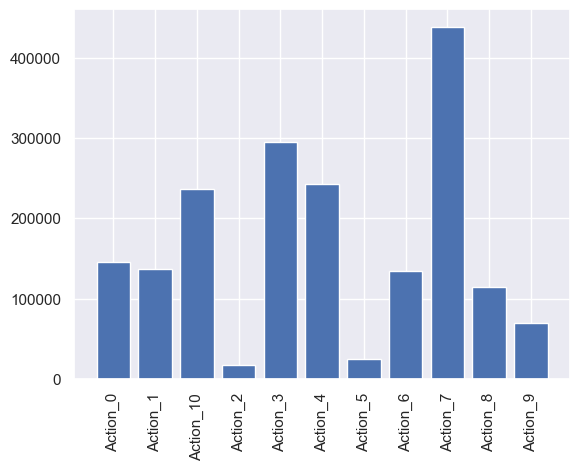

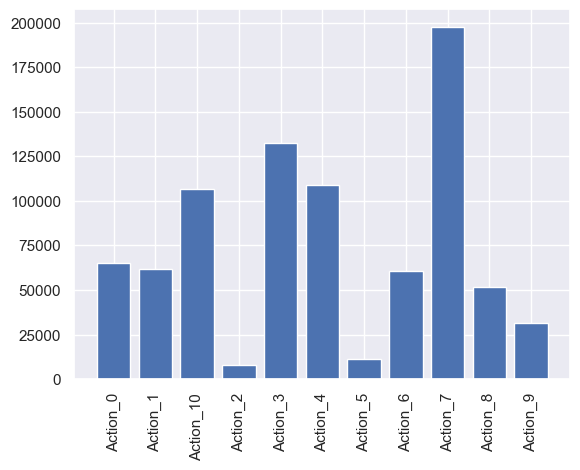

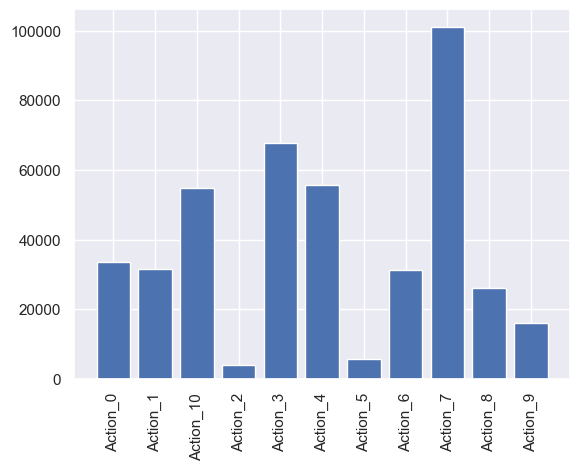

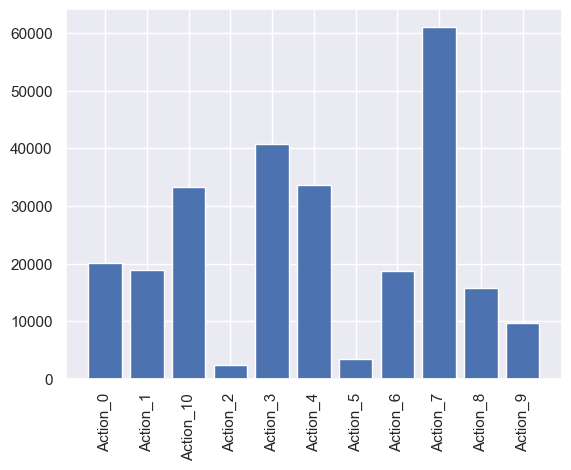

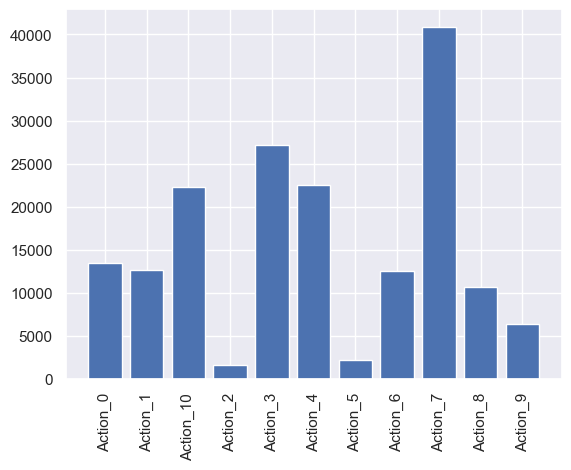

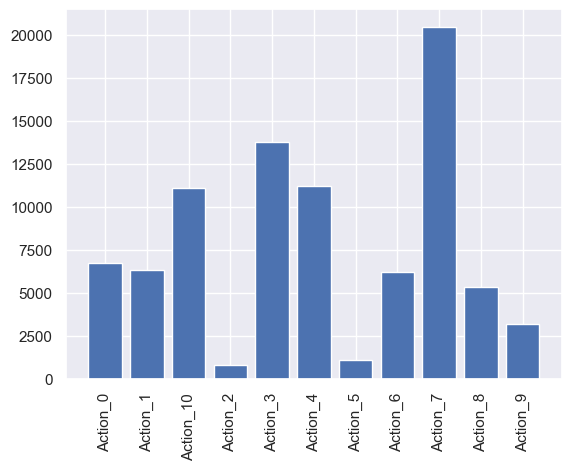

In [207]:
for last in [50, 30, 10, 5, 3, 2, 1]:
    
    df2 = df.groupby("session_num")["action_name"].agg(list).reset_index()

    unique_actions = sorted(df["action_name"].unique())
    d = {x: 0 for x in unique_actions}

    def decorator(last_x, d):
        def count_last_x(lst):
            for x in lst[-last_x:]:
                d[x] += 1
        return count_last_x

    df2["action_name"] = df2["action_name"].apply(decorator(last, d))
    
    plt.bar(x=d.keys(), height=d.values())
    plt.xticks(rotation=90)
    plt.show()


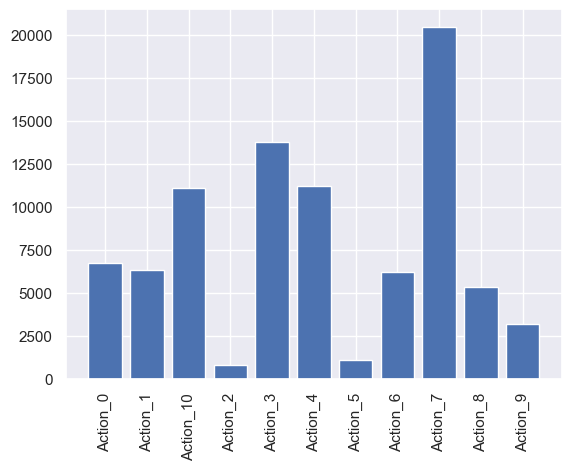

In [208]:
# plt.figure(figsize=(12, 8))
plt.bar(x=d.keys(), height=d.values())
plt.xticks(rotation=90)
plt.show()

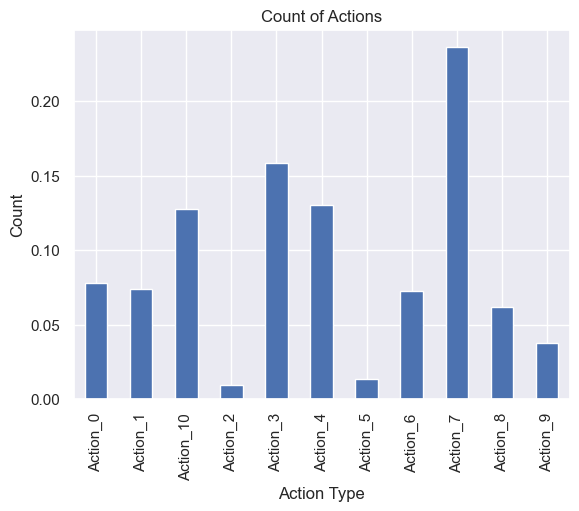

In [209]:
counts = df['action_name'].value_counts(normalize=True)
counts.sort_index(inplace=True)

counts.plot(kind='bar')
plt.title("Count of Actions")
plt.xlabel("Action Type")
plt.ylabel("Count")
plt.show()

# here we can see that the distribution changes